# Day 6: Handling Class Imbalance in Trading

## 🎯 Learning Objectives
- Understand class imbalance problem in finance
- Apply sampling techniques (SMOTE, undersampling)
- Use cost-sensitive learning
- Proper evaluation with imbalanced data

---

## 📚 Theory: Class Imbalance

### Why Imbalance Matters
In finance, extreme events are rare:
- Large positive returns: ~5% of days
- Crashes: ~1% of days
- Default events: <1% of companies

### Problem with Standard Methods
- Model predicts majority class always
- High accuracy but useless predictions
- Misses the rare but important events

### Solutions

| Approach | Description |
|----------|-------------|
| Undersampling | Remove majority class samples |
| Oversampling | Duplicate minority class samples |
| SMOTE | Synthetic minority oversampling |
| Class Weights | Penalize majority class errors less |
| Threshold Adjustment | Lower decision threshold |

### SMOTE Algorithm
1. For each minority sample, find k nearest neighbors
2. Randomly select neighbor
3. Create synthetic sample along line connecting them

### Proper Evaluation
- **Precision-Recall curve** (not ROC)
- **F1 score** (harmonic mean)
- **Matthews Correlation Coefficient**

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             precision_recall_curve, average_precision_score,
                             roc_auc_score, matthews_corrcoef)
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=7*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1758 days


In [2]:
# Create imbalanced dataset: Predict large up moves (top 10%)
df = pd.DataFrame(index=prices.index)
df['price'] = prices
df['return'] = returns

# Features
for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

df['volatility_10'] = returns.rolling(10).std()
df['volatility_20'] = returns.rolling(20).std()
df['ma_ratio'] = prices / prices.rolling(20).mean() - 1

# RSI
delta = prices.diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))

# Create IMBALANCED target: Top 10% returns
df['next_return'] = returns.shift(-1)
threshold = df['next_return'].quantile(0.9)  # Top 10%
df['target'] = (df['next_return'] > threshold).astype(int)

df = df.dropna()

print(f"\n📊 Dataset: {len(df)} samples")
print(f"\n🎯 Class Distribution (IMBALANCED):")
print(f"   Class 0 (Normal): {(df['target']==0).sum()} ({(df['target']==0).mean():.1%})")
print(f"   Class 1 (Large Up): {(df['target']==1).sum()} ({(df['target']==1).mean():.1%})")
print(f"\nImbalance Ratio: {(df['target']==0).sum() / (df['target']==1).sum():.1f}:1")


📊 Dataset: 1737 samples

🎯 Class Distribution (IMBALANCED):
   Class 0 (Normal): 1563 (90.0%)
   Class 1 (Large Up): 174 (10.0%)

Imbalance Ratio: 9.0:1


In [3]:
# Prepare data
feature_cols = ['momentum_1', 'momentum_5', 'momentum_10', 'momentum_20',
                'volatility_10', 'volatility_20', 'ma_ratio', 'rsi']

X = df[feature_cols]
y = df['target']

# Split
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)} (Pos: {y_train.sum()})")
print(f"Test: {len(X_test)} (Pos: {y_test.sum()})")

Train: 1389 (Pos: 151)
Test: 348 (Pos: 23)


In [4]:
# Baseline: Standard model (no handling)
rf_baseline = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

y_pred_baseline = rf_baseline.predict(X_test_scaled)
y_proba_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("BASELINE MODEL (No Imbalance Handling)")
print("="*60)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_baseline):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.2%}")
print(f"F1: {f1_score(y_test, y_pred_baseline):.2%}")

print("\n" + classification_report(y_test, y_pred_baseline, target_names=['Normal', 'Large Up']))


BASELINE MODEL (No Imbalance Handling)

Accuracy: 93.10%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%

              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96       325
    Large Up       0.00      0.00      0.00        23

    accuracy                           0.93       348
   macro avg       0.47      0.50      0.48       348
weighted avg       0.87      0.93      0.90       348



In [5]:
# Method 1: Class Weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

rf_weighted = RandomForestClassifier(n_estimators=100, max_depth=5, 
                                     class_weight=weight_dict, random_state=42)
rf_weighted.fit(X_train_scaled, y_train)

y_pred_weighted = rf_weighted.predict(X_test_scaled)
y_proba_weighted = rf_weighted.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("METHOD 1: CLASS WEIGHTS")
print("="*60)
print(f"Weights: Class 0 = {weight_dict[0]:.2f}, Class 1 = {weight_dict[1]:.2f}")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_weighted):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_weighted, zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_weighted):.2%}")
print(f"F1: {f1_score(y_test, y_pred_weighted):.2%}")


METHOD 1: CLASS WEIGHTS
Weights: Class 0 = 0.56, Class 1 = 4.60

Accuracy: 87.07%
Precision: 13.33%
Recall: 17.39%
F1: 15.09%


In [6]:
# Method 2: Random Undersampling
from sklearn.utils import resample

# Separate classes
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_train_df['target'] = y_train.values

majority = X_train_df[X_train_df['target'] == 0]
minority = X_train_df[X_train_df['target'] == 1]

# Undersample majority
majority_downsampled = resample(majority, replace=False, 
                                n_samples=len(minority), random_state=42)

# Combine
X_train_under = pd.concat([majority_downsampled, minority])
y_train_under = X_train_under['target']
X_train_under = X_train_under.drop('target', axis=1)

rf_under = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_under.fit(X_train_under, y_train_under)

y_pred_under = rf_under.predict(X_test_scaled)
y_proba_under = rf_under.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("METHOD 2: RANDOM UNDERSAMPLING")
print("="*60)
print(f"Training samples: {len(X_train_under)} (balanced)")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_under):.2%}")
print(f"Precision: {precision_score(y_test, y_pred_under, zero_division=0):.2%}")
print(f"Recall: {recall_score(y_test, y_pred_under):.2%}")
print(f"F1: {f1_score(y_test, y_pred_under):.2%}")


METHOD 2: RANDOM UNDERSAMPLING
Training samples: 302 (balanced)

Accuracy: 75.00%
Precision: 13.64%
Recall: 52.17%
F1: 21.62%


In [7]:
# Method 3: Threshold Adjustment
# Use baseline model probabilities but lower threshold

thresholds = [0.5, 0.3, 0.2, 0.1]

print("\n" + "="*60)
print("METHOD 3: THRESHOLD ADJUSTMENT")
print("="*60)

threshold_results = []
for thresh in thresholds:
    y_pred_thresh = (y_proba_baseline >= thresh).astype(int)
    
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1': f1_score(y_test, y_pred_thresh)
    })

thresh_df = pd.DataFrame(threshold_results)
print(thresh_df.to_string(index=False))


METHOD 3: THRESHOLD ADJUSTMENT
 Threshold  Precision   Recall       F1
       0.5   0.000000 0.000000 0.000000
       0.3   0.166667 0.086957 0.114286
       0.2   0.142857 0.217391 0.172414
       0.1   0.103774 0.478261 0.170543


In [8]:
# Compare all methods
methods = {
    'Baseline': (y_pred_baseline, y_proba_baseline),
    'Class Weights': (y_pred_weighted, y_proba_weighted),
    'Undersampling': (y_pred_under, y_proba_under),
    'Threshold 0.2': ((y_proba_baseline >= 0.2).astype(int), y_proba_baseline)
}

print("\n" + "="*70)
print("COMPREHENSIVE METHOD COMPARISON")
print("="*70)

comparison = []
for name, (pred, proba) in methods.items():
    comparison.append({
        'Method': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred, zero_division=0),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred),
        'MCC': matthews_corrcoef(y_test, pred),
        'AUC': roc_auc_score(y_test, proba)
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))


COMPREHENSIVE METHOD COMPARISON
       Method  Accuracy  Precision   Recall       F1       MCC      AUC
     Baseline  0.931034   0.000000 0.000000 0.000000 -0.014281 0.585953
Class Weights  0.870690   0.133333 0.173913 0.150943  0.083130 0.587291
Undersampling  0.750000   0.136364 0.521739 0.216216  0.164554 0.661137
Threshold 0.2  0.862069   0.142857 0.217391 0.172414  0.103324 0.585953


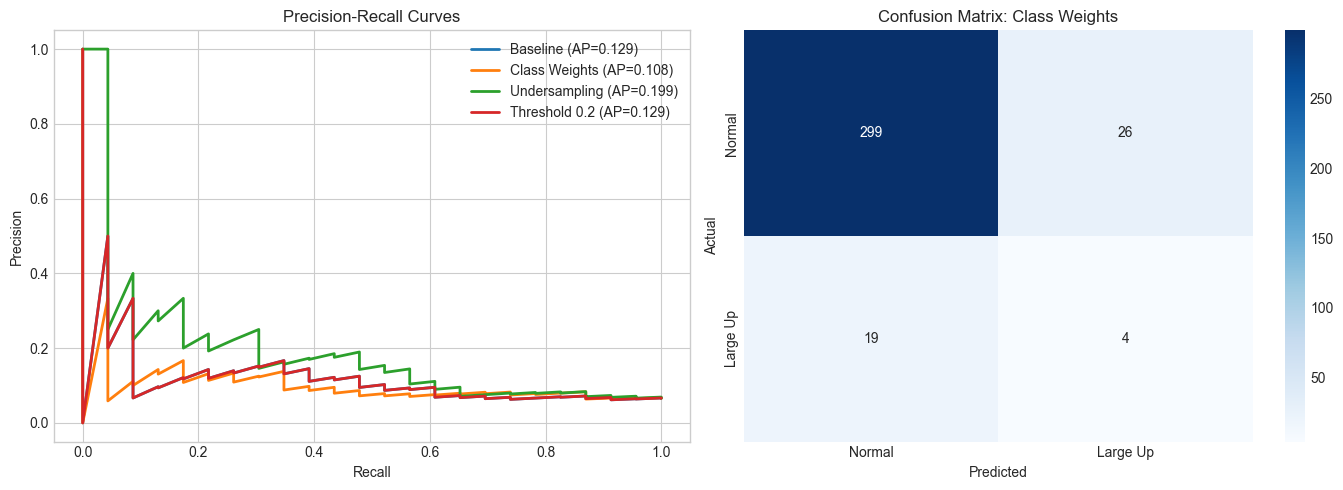

In [9]:
# Precision-Recall Curves (better for imbalanced data)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR Curves
for name, (_, proba) in methods.items():
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    axes[0].plot(recall, precision, linewidth=2, label=f'{name} (AP={ap:.3f})')

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curves')
axes[0].legend()

# Confusion matrices
best_method = 'Class Weights'
cm = confusion_matrix(y_test, methods[best_method][0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Large Up'],
            yticklabels=['Normal', 'Large Up'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Confusion Matrix: {best_method}')

plt.tight_layout()
plt.show()

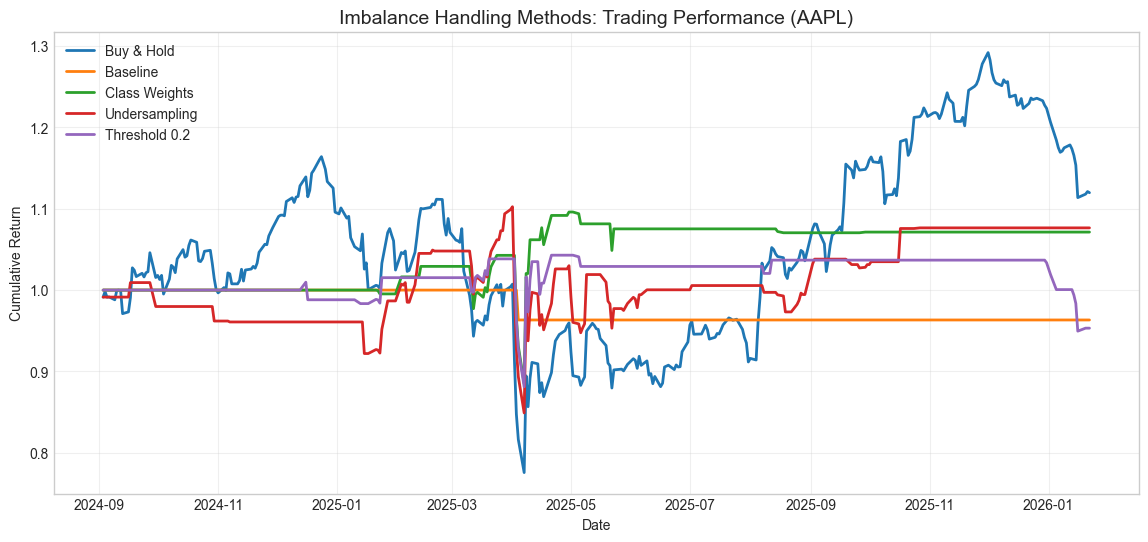

In [10]:
# Trading Strategy Backtest
backtest = pd.DataFrame(index=y_test.index)
backtest['actual_return'] = returns_test.values

for name, (pred, _) in methods.items():
    backtest[f'{name}_signal'] = pred
    backtest[f'{name}_return'] = pred * backtest['actual_return']
    backtest[f'{name}_cum'] = (1 + backtest[f'{name}_return']).cumprod()

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
for name in methods.keys():
    plt.plot(backtest.index, backtest[f'{name}_cum'], label=name, linewidth=2)
plt.title(f'Imbalance Handling Methods: Trading Performance ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
# Strategy Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    trades = (returns != 0).sum()
    return total, sharpe, mdd, trades

print("\n" + "="*70)
print("STRATEGY PERFORMANCE")
print("="*70)

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10} {'Trades':>8}")
print("-" * 65)

total, sharpe, mdd, _ = calc_metrics(backtest['actual_return'], backtest['buy_hold_cum'])
print(f"{'Buy & Hold':<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%} {len(backtest):>8}")

for name in methods.keys():
    total, sharpe, mdd, trades = calc_metrics(backtest[f'{name}_return'], backtest[f'{name}_cum'])
    print(f"{name:<20} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%} {trades:>8}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD   Trades
-----------------------------------------------------------------
Buy & Hold                 11.97%       0.25    -33.36%      348
Baseline                   -3.67%      -2.45     -3.67%        1
Class Weights               7.13%       0.08    -15.14%       30
Undersampling               7.65%       0.13    -22.99%       88
Threshold 0.2              -4.68%      -0.38    -15.14%       35


In [12]:
# Current prediction
latest_scaled = scaler.transform(X.iloc[[-1]])

print("\n" + "="*60)
print(f"📊 CURRENT LARGE MOVE PREDICTIONS FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"Threshold: Top 10% return (>{threshold*100:.2f}%)")

for name, model in [('Baseline', rf_baseline), ('Class Weights', rf_weighted), ('Undersampling', rf_under)]:
    proba = model.predict_proba(latest_scaled)[0, 1]
    pred = 'LARGE UP EXPECTED' if proba > 0.3 else 'Normal Day'
    emoji = '🚀' if proba > 0.3 else '📊'
    print(f"\n{name}: {emoji} {pred} (Prob: {proba:.1%})")


📊 CURRENT LARGE MOVE PREDICTIONS FOR AAPL

Date: 2026-01-22
Threshold: Top 10% return (>2.16%)

Baseline: 📊 Normal Day (Prob: 11.0%)

Class Weights: 🚀 LARGE UP EXPECTED (Prob: 30.8%)

Undersampling: 🚀 LARGE UP EXPECTED (Prob: 40.0%)


---

## 🏢 Real-World Applications

| Company | Imbalance Handling Use |
|---------|----------------------|
| JP Morgan | Fraud detection |
| Goldman Sachs | Default prediction |
| Two Sigma | Extreme event prediction |
| Citadel | Rare signal detection |

### Key Interview Points
1. **Why accuracy is misleading?** - 90% accuracy means nothing if 90% is one class
2. **SMOTE caution?** - Creates synthetic samples, can overfit in time series
3. **Best metric?** - F1 or Matthews Correlation Coefficient
4. **Time series note?** - Don't SMOTE across time, use class weights instead

---
## 📅 Tomorrow: Week 6.1 Review & Interview Prep